In [114]:
#pip install tensorflow

In [1]:
import tensorflow as tf     # TensorFlow es una biblioteca de código abierto de Google para computación numérica y aprendizaje automático
from tensorflow import keras    # Keras es una API de alto nivel que permite construir y entrenar modelos de redes neuronales de forma sencilla.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm   # Herramienta para mostrar barras de progreso en bucles. Muy útil para saber cuánto falta en ejecuciones largas.
from IPython import display # Permite controlar cómo se muestran salidas en entornos como Jupyter Notebook (por ejemplo, limpiar salidas anteriores o mostrar imágenes dinámicamente)

Fashion MNIST 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() #imágenes y etiquetas para entrenamiento, imágenes y etiquetas para test 
x_train = x_train.astype(np.float32) / 255.0 # Convierte los valores de píxeles de entrenamiento a flotantes (float32) y los normaliza a un rango de 0 a 1 dividiendo por 255 (los valores originales van de 0 a 255).
x_test = x_test.astype(np.float32) / 255.0  # Convierte los valores de píxeles de test a flotantes (float32) y los normaliza a un rango de 0 a 1 dividiendo por 255 (los valores originales van de 0 a 255).
x_train.shape, x_test.shape # Devuelve las formas (dimensiones) de los conjuntos x_train y x_test

# Indica que hay 60,000 imágenes de entrenamiento y 10,000 de prueba, cada una de 28x28 píxeles, esta división viene predefinida por el propio conjunto de datos.

((60000, 28, 28), (10000, 28, 28))

Limitamos la cantidad de elementos del conjunto para hacer pruebas con bajo coste computacional

In [3]:
x_train = x_train[:60000]
y_train = y_train[:60000]

x_test = x_test[:10000]
y_test = y_test[:10000]

x_train.shape, x_test.shape # Devuelve las formas (dimensiones) de los conjuntos x_train y x_test


((60000, 28, 28), (10000, 28, 28))

Representamos algunas imágenes del dataset

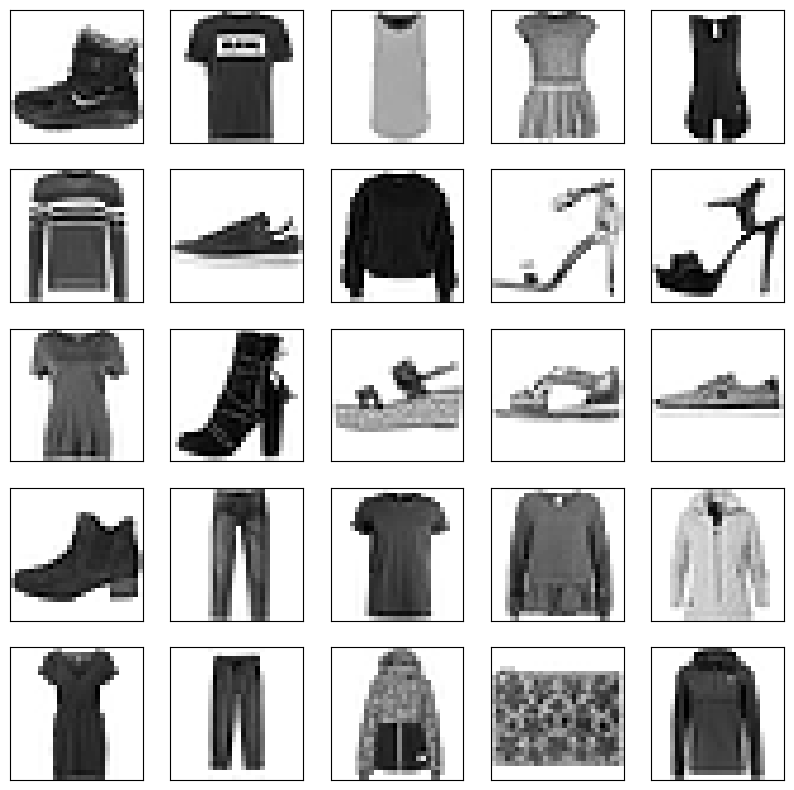

In [4]:
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

`tf.data.Dataset.from_tensor_slices(x_train)`: Crea un objeto `tf.data.Dataset` a partir del array `x_train`. Cada imagen (28x28) es tratada como un elemento independiente.

`.shuffle(1000)`: Mezcla aleatoriamente los elementos del conjunto usando un buffer de tamaño 1000. Esto ayuda a romper cualquier estructura en los datos y mejora la generalización del modelo.

`drop_remainder=True` asegura que se descarten los últimos elementos si no completan un lote completo.

`prefetch(1)` permite preparar el siguiente lote en segundo plano mientras el modelo entrena con el lote actual, lo que acelera el entrenamiento.

In [6]:
batch_size = 32

def create_batch(x_train):

    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)    

    return dataset

`generator = keras.models.Sequential([`   # Se define el generador como un modelo secuencial de Keras, lo que significa que las capas se apilan una tras otra en orden.

`keras.layers.Dense(7 * 7 * 128, input_shape =[num_features])`: Es una capa de 6272 neuronas, cada neurona toma como entrada el vector de ruido de dimensión 100 y da una salida, obteniendo así un vector de tamaño 6272.

`keras.layers.Reshape([7, 7, 128])`: Reorganiza la salida anterior en un tensor de forma (7, 7, 128) como si fuera una imagen pequeña con 128 canales de profundidad.

`keras.layers.BatchNormalization()`: Normaliza la activación de la capa anterior para estabilizar y acelerar el entrenamiento.

`keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding = "same", activation = "selu")`: Aplica una convolución transpuesta para aumentar la resolución de la imagen a 14×14. Usa 64 filtros de tamaño 5x5, con stride (2, 2) (vertical y horizontal), y padding (same). La activación usada es SELU (Scaled Exponential Linear Unit), que promueve auto-normalización.

`keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding = "same", activation = "tanh")`: Segunda convolución transpuesta. Aumenta la resolución de (14, 14) a (28, 28), que es el tamaño final deseado para imágenes MNIST. Solo usa 1 filtro, ya que las imágenes de MNIST son en escala de grises (1 canal). Activación tanh, que produce salidas en el rango [-1, 1]. Esto implica que las imágenes reales también deberán estar normalizadas a este rango para que la función de pérdida sea coherente.



In [7]:
num_features = 100 # Número de variables latentes (también llamadas ruido de entrada)

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding = "same", activation = "selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding = "same", activation = "tanh"),
])
generator.summary()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,705 (3.21 MB)

 Trainable params: 840,321 (3.21 MB)

 Non-trainable params: 384 (1.50 KB)

`discriminator = keras.models.Sequential([`: Se define el discriminador como un modelo secuencial de Keras, en el que las capas se apilan una tras otra.

`keras.layers.Conv2D(64, (5, 5), (2, 2), padding="same", input_shape =[28, 28, 1])`: Aplica una convolución con 64 filtros de tamaño 5x5, stride (2, 2) (para reducir la resolución de 28x28 a 14x14). La imagen de entrada tiene una forma de 28x28 píxeles con 1 canal (escala de grises).

`keras.layers.LeakyReLU(0.2)`: Función de activación LeakyReLU con un coeficiente de 0.2, que permite un pequeño gradiente cuando la activación es negativa (para evitar "morir" durante el entrenamiento).

`keras.layers.Dropout(0.3)`: Regularización mediante dropout, apaga el 30% de las neuronas aleatoriamente en cada paso para prevenir el sobreajuste (overfitting).

`keras.layers.Conv2D(128, (5, 5), (2, 2), padding="same")`: Aplica una segunda convolución con 128 filtros, tamaño de kernel 5x5, stride (2, 2), reduciendo la resolución a 7x7.

`keras.layers.LeakyReLU(0.2)`: Otra capa de activación LeakyReLU, similar a la anterior.

`keras.layers.Dropout(0.3)`: Aplica nuevamente dropout, apagando el 30% de las neuronas para reducir el riesgo de sobreajuste.

`keras.layers.Flatten()`: Aplana el tensor de 3 dimensiones (7, 7, 128) a un vector 1D de 6272 valores, listo para ser procesado por una capa densa.

`keras.layers.Dense(1, activation='sigmoid')`: Capa de salida densa con una sola neurona que utiliza una activación sigmoide, produciendo un valor entre 0 y 1 que indica la probabilidad de que la imagen sea real (1) o falsa (0).


In [8]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding="same", input_shape =[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

`discriminator.compile(loss = "binary_crossentropy", optimizer = "adam")`: Compila el discriminador usando la pérdida de entropía cruzada binaria (ideal para problemas de clasificación binaria) y el optimizador Adam (una combinación de gradiente estocástico con adaptaciones de tasa de aprendizaje).

`discriminator.trainable = False`: Establece el discriminador como no entrenable. Esto se hace porque durante el entrenamiento de la GAN, solo queremos actualizar los pesos del generador cuando entrenamos el gan. El discriminador se mantiene fijo mientras el generador intenta mejorar para engañarlo.

`gan = keras.models.Sequential([generator, discriminator])`
Se define el modelo GAN (Generative Adversarial Network) como una secuencia de los modelos generador y discriminador.

`gan.compile(loss = "binary_crossentropy", optimizer = "adam")`: Compila el modelo GAN usando la misma pérdida de entropía cruzada binaria que se utiliza en el discriminador, ya que la tarea es hacer que el generador produzca imágenes más realistas.

In [9]:

discriminator.compile(loss = "binary_crossentropy", optimizer = "adam")

discriminator.trainable = False

gan = keras.models.Sequential([generator, discriminator])

gan.compile(loss = "binary_crossentropy", optimizer = "adam")

In [10]:
seed = tf.random.normal(shape=[batch_size, 100])    # Se generan tantos vectores latentes como imágenes tengamos en un batch.

# Es constante, se repite al final de cada época para ver si ha mejorado su técnica en esos ejemplos concretos.

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers

    # Save generated images before training the GAN.
    generate_and_save_images(generator, 0, seed) 
    
    for epoch in tqdm(range(epochs)):
        print()
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset: # Cada X_batch es de tamaño 32x28x28 y en dataset tenemos n batches
            
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)

            # Train the discriminator on real and fake images
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # Barajar ambos en conjunto
            indices = tf.random.shuffle(tf.range(2 * batch_size))
            X_fake_and_real = tf.gather(X_fake_and_real, indices)
            y1 = tf.gather(y1, indices)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # Entrenamiento del generador para engañar al discriminador
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)   # El discriminador con pesos congelados evalúa las imágenes y se comparan con el 1 para ajustar los pesos del generador
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        # Save generated images once at the end of each epoch
        generate_and_save_images(generator, epoch + 1, seed)

In [11]:
seed = tf.random.normal(shape=[batch_size, 100])    # Se generan tantos vectores latentes como imágenes tengamos en un batch.

# Es constante, se repite al final de cada época para ver si ha mejorado su técnica en esos ejemplos concretos.

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    
    # Listas para guardar TODAS las pérdidas de cada batch
    d_losses = []
    g_losses = []

    generate_and_save_images(generator, 0, seed) 

    for epoch in tqdm(range(epochs)):
        print()
        print("Epoch {}/{}".format(epoch + 1, epochs))
        
        for X_batch in dataset: # Cada X_batch es de tamaño 32x28x28 y en dataset tenemos n batches
            
            # === Entrenamiento del discriminador ===
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Barajar
            indices = tf.random.shuffle(tf.range(2 * batch_size))
            X_fake_and_real = tf.gather(X_fake_and_real, indices)
            y1 = tf.gather(y1, indices)
            
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_fake_and_real, y1)
            d_losses.append(d_loss)  # Guardamos cada batch
            
            # === Entrenamiento del generador ===
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            g_losses.append(g_loss)  # Guardamos cada batch
            
        generate_and_save_images(generator, epoch +1, seed)

    # Figura 1: pérdidas por batch
    plt.figure(figsize=(12, 5))
    plt.plot(d_losses, label="Discriminador", alpha=0.7)
    plt.plot(g_losses, label="Generador", alpha=0.7)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Evolución de la loss por batch")
    plt.legend()
    plt.show()

    # Figura 2: medias móviles
    plt.figure(figsize=(12,6))
    window_size = 50
    plt.plot(np.convolve(d_losses, np.ones(window_size)/window_size, mode='valid'), 
             label=f"Discriminador (media {window_size} batches)", color='blue')
    plt.plot(np.convolve(g_losses, np.ones(window_size)/window_size, mode='valid'), 
             label=f"Generador (media {window_size} batches)", color='orange')
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Medias móviles de las pérdidas")
    plt.legend()
    plt.show()


In [12]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')

    # Save the generated images as a PNG file
    plt.savefig('image_epoch_{:04d}.png'.format(epoch)) 
    plt.close(fig)

Hacemos el reshape por temas computacionales, `(60000, 28, 28) → (60000, 28, 28, 1)`, de esta forma se entiende que es 1 único canal
`tanh` genera salidas en el intervalo `[-1,1]`, como `x_train` se normalizó a `[0, 1]` multiplicamos *2 y -1 para trasladar al `[-1,1]`

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20


  5%|▌         | 1/20 [02:10<41:15, 130.28s/it]


Epoch 2/20


 10%|█         | 2/20 [04:45<43:33, 145.20s/it]


Epoch 3/20


 15%|█▌        | 3/20 [07:31<43:46, 154.50s/it]


Epoch 4/20


 20%|██        | 4/20 [10:27<43:27, 162.97s/it]


Epoch 5/20


 25%|██▌       | 5/20 [13:15<41:13, 164.92s/it]


Epoch 6/20


 30%|███       | 6/20 [16:00<38:27, 164.79s/it]


Epoch 7/20


 35%|███▌      | 7/20 [18:41<35:28, 163.76s/it]


Epoch 8/20


 40%|████      | 8/20 [21:23<32:38, 163.19s/it]


Epoch 9/20


 45%|████▌     | 9/20 [24:04<29:44, 162.26s/it]


Epoch 10/20


 50%|█████     | 10/20 [26:44<26:57, 161.79s/it]


Epoch 11/20


 55%|█████▌    | 11/20 [29:33<24:34, 163.84s/it]


Epoch 12/20


 60%|██████    | 12/20 [32:32<22:27, 168.40s/it]


Epoch 13/20


 65%|██████▌   | 13/20 [35:25<19:49, 169.91s/it]


Epoch 14/20


 70%|███████   | 14/20 [38:21<17:11, 171.84s/it]


Epoch 15/20


 75%|███████▌  | 15/20 [41:14<14:20, 172.07s/it]


Epoch 16/20


 80%|████████  | 16/20 [44:13<11:36, 174.17s/it]


Epoch 17/20


 85%|████████▌ | 17/20 [47:06<08:41, 173.86s/it]


Epoch 18/20


 90%|█████████ | 18/20 [49:58<05:46, 173.21s/it]


Epoch 19/20


 95%|█████████▌| 19/20 [52:36<02:48, 168.66s/it]


Epoch 20/20


100%|██████████| 20/20 [55:19<00:00, 165.99s/it]


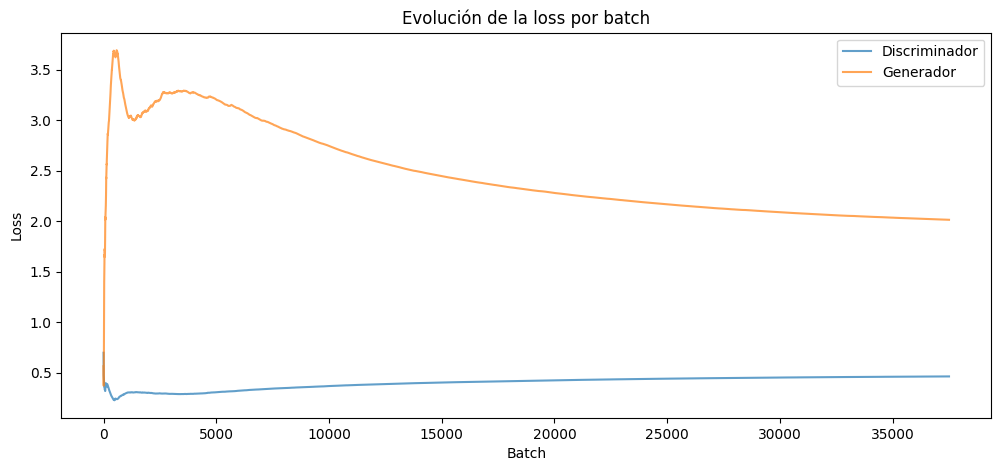

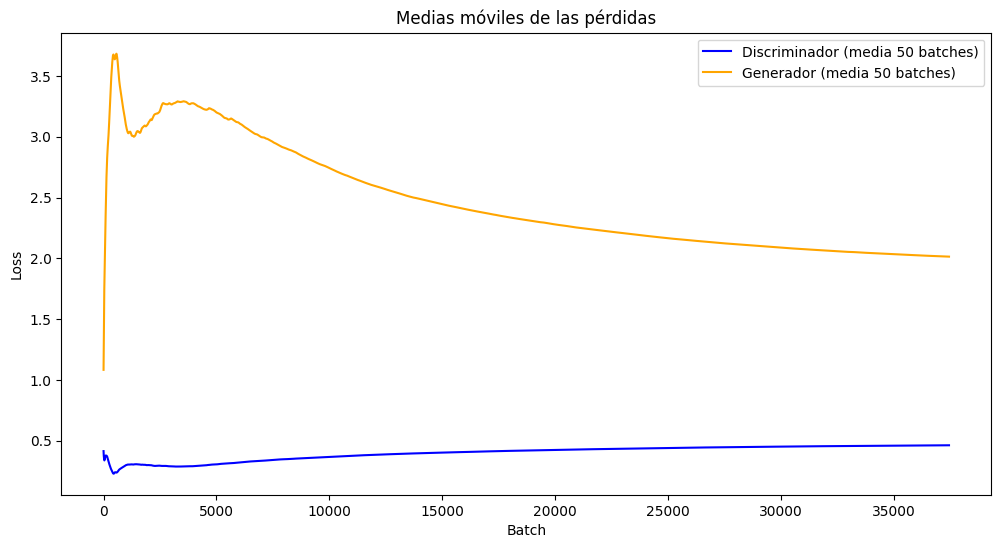

In [13]:
# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2 - 1
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 20)